In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rioxarray as rio
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysheds.grid import Grid
from rasterstats import zonal_stats
from shapely.geometry import Polygon, box, shape

plt.style.use("ggplot")

# Svalbard catchment delineation

# Notebook 03: Catchment delineation

**Using the 10 m elevation model notebook requires a large machine (240 GB memory). The 40 m raster should be OK on a standard machine. A medium-size machine is probably wise for the 20 m raster (e.g. 48 GB).**

## 1. User options

In [2]:
# DEM resolution to use (2, 10, 20 or 40 m)
# Note that the 2 m data has not been processed yet - see notebook 1
dem_res = 40

# Whether to snap outlets to catchments with a minimum size
# Either a number or None.
# Usually a good idea to set this on Svalbard!
min_size_km2 = 10

# File with outlet co-ords (lat/lon)
outlet_xlsx = r"../data/svalbard_example_outlet_coords.xlsx"

# Column in Excel file with unique outlet IDs
cat_id_col = "site_id"

# Whether to use datasets with "burned" streams and lakes (recommend True)
use_burn = True

assert dem_res in [10, 20, 40], "'dem_res' must be 10, 20 or 40."

## 2. Read outlet co-ords

In [3]:
# Read outlet co-ords for Varna and Yantra
outlet_df = pd.read_excel(outlet_xlsx)
outlet_gdf = gpd.GeoDataFrame(
    outlet_df,
    geometry=gpd.points_from_xy(outlet_df.lon, outlet_df.lat, crs="epsg:4326"),
)

# Reproject to match Svalbard DEM
outlet_gdf = outlet_gdf.to_crs("epsg:25833")
outlet_gdf["x_proj"] = outlet_gdf["geometry"].x
outlet_gdf["y_proj"] = outlet_gdf["geometry"].y
outlet_gdf

,site_id,name,lat,lon,orig_area_km2,geometry,x_proj,y_proj
0,1,Adventelva,78.20486,15.81774,429,POINT (518659.721 8681362.586),518659.721449,8.681363e+06
1,2,Bolterelva,78.16333,15.98027,37,POINT (522445.746 8676785.34),522445.746161,8.676785e+06
2,3,De Geerelva,78.33822,16.31238,81,POINT (529611.501 8696447.717),529611.501078,8.696448e+06
3,4,Ebbaelva,78.70824,16.59977,55,POINT (534964.666 8737890.229),534964.666295,8.737890e+06
4,5,Endalselva,78.19590,15.81446,31,POINT (518598.795 8680361.68),518598.794562,8.680362e+06
5,6,Foxelva,78.15919,16.20452,26,POINT (527589.391 8676419.219),527589.391459,8.676419e+06
6,7,Gipsdalselva,78.44082,16.57706,230,POINT (535273.566 8708041.737),535273.565770,8.708042e+06
7,8,Sassenelva,78.33203,16.86129,726,POINT (542015.235 8696093.154),542015.235270,8.696093e+06
8,9,Todalselva,78.17167,15.86485,36,POINT (519789.361 8677674.353),519789.360770,8.677674e+06


## 3. Delineate catchments

In [4]:
# Read raster data
if use_burn:
    fdir_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{dem_res}m/merged/svalbard_{dem_res}m_fdir_burn_proj.tif"
    facc_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{dem_res}m/merged/svalbard_{dem_res}m_facc_burn_proj.tif"
else:
    fdir_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{dem_res}m/merged/svalbard_{dem_res}m_fdir_noburn_proj.tif"
    facc_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{dem_res}m/merged/svalbard_{dem_res}m_facc_noburn_proj.tif"

fdir_grid = Grid.from_raster(fdir_path)
fdir = fdir_grid.read_raster(fdir_path)
facc_grid = Grid.from_raster(facc_path)
facc = facc_grid.read_raster(facc_path)
dirmap = (1, 2, 3, 4, 5, 6, 7, 8)

assert facc.crs == outlet_gdf.crs

cat_ids = []
cat_geoms = []
for idx, row in outlet_gdf.iterrows():
    cat_id = row[cat_id_col]
    x = row["x_proj"]
    y = row["y_proj"]

    if min_size_km2:
        # Convert min area to number of pixels
        acc_thresh = int((min_size_km2 * 1e6) / (dem_res**2))
        x_snap, y_snap = facc_grid.snap_to_mask(facc > acc_thresh, (x, y))
    else:
        x_snap, y_snap = x, y

    # Delineate catchment
    fdir = fdir.astype(np.int32)
    fdir.nodata = int(fdir.nodata)
    catch = fdir_grid.catchment(
        x=x_snap,
        y=y_snap,
        fdir=fdir,
        dirmap=dirmap,
        xytype="coordinate",
    )

    # Create a vector representation of the catchment mask
    catch_view = fdir_grid.view(catch, dtype=np.uint8)
    shapes = fdir_grid.polygonize(catch_view)
    for shapedict, value in shapes:
        # 'value' is 1 for the catchment and 0 for "not the catchment"
        if value == 1:
            cat_ids.append(cat_id)
            cat_geoms.append(shape(shapedict))

# Build catchment gdf
cat_gdf = gpd.GeoDataFrame({cat_id_col: cat_ids, "geometry": cat_geoms}, crs=facc.crs)
cat_gdf = cat_gdf.merge(outlet_df, on=cat_id_col)
cat_gdf = cat_gdf[list(outlet_df.columns) + ["geometry"]]
cat_gdf.geometry = cat_gdf.geometry.apply(
    lambda p: nivapy.spatial.remove_polygon_holes(p)
)
cat_gdf = cat_gdf.dissolve(by=cat_id_col).reset_index()
cat_gdf["area_km2"] = cat_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6

cat_gdf.head()

,site_id,geometry,name,lat,lon,orig_area_km2,area_km2
0,1,"POLYGON ((529160 8689320, 529160 8689280, 5290...",Adventelva,78.20486,15.81774,429,426.046486
1,2,"MULTIPOLYGON (((527240 8673040, 527200 8673040...",Bolterelva,78.16333,15.98027,37,37.150736
2,3,"POLYGON ((528600 8697040, 528600 8697000, 5285...",De Geerelva,78.33822,16.31238,81,81.142961
3,4,"POLYGON ((542000 8744960, 542000 8744920, 5418...",Ebbaelva,78.70824,16.59977,55,54.526155
4,5,"POLYGON ((518880 8680600, 518880 8680560, 5188...",Endalselva,78.19590,15.81446,31,27.332096


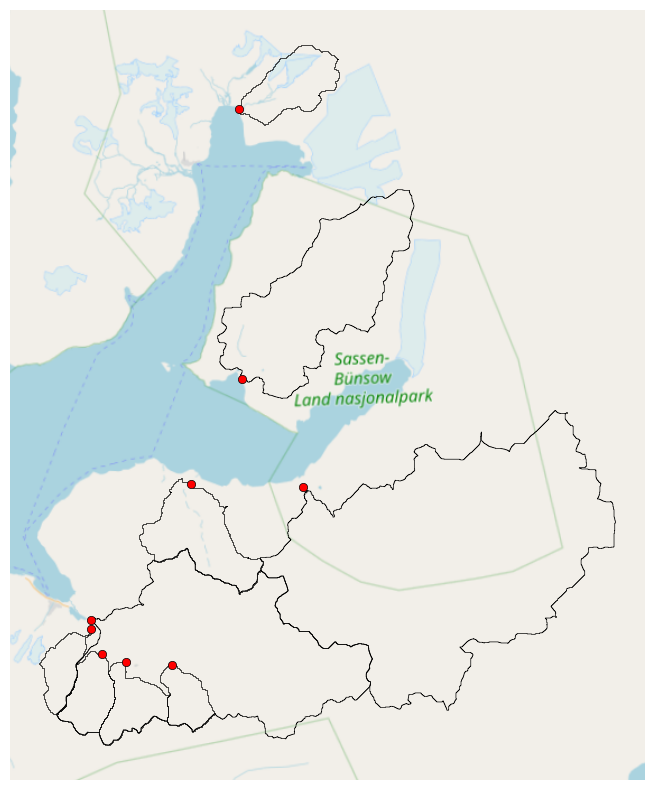

In [5]:
# Plot
ax = cat_gdf.plot(color="none", edgecolor="black", figsize=(10, 10))
outlet_gdf.plot(ax=ax, color="red", edgecolor="black")
cx.add_basemap(
    ax, crs=cat_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, attribution=False
)
ax.set_axis_off()

In [6]:
# cat_gdf.to_file('cats.shp')
# outlet_gdf.to_file('outlets.shp')